# Exercise 1

In [156]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
from matplotlib.animation import FuncAnimation
from scipy.special import erfc
import os
from tqdm import tqdm
from numba import jit, prange

In [157]:
np.random.seed(42)
os.makedirs('media', exist_ok=True)

### 1.1 Vibrating string

A. (0.5 point) Discretize the wave equation, and write it in a form suitable for
implementing in a computer program. Assume that the boundaries are fixed, 	(x =
0, t) = 0, 	(x = L, t) = 0. L is the length of the string. Take L = 1 for simplicity.
Divide the string in N intervals, so that the interval length is x = L/N. Also
consider the boundary cases.

In [158]:
def solve_wave(psi_init, L, c, T, Nx, dt):
    """Solves the wave equation using the finite difference method (explicit scheme) and returns the vibration amplitude psi(x,t) matrix of all time steps.
    
    Args:
    psi_init (function): Initial condition function to generate psi(x,0)
    L (float): Length of the string
    c (float): Wave speed
    T (float): Total time to simulate
    Nx (int): Total number of spatial intervals
    dt (float): Time step size
    """
    # Discretization
    dx = L/Nx # spatial step size
    Nt = int(T/dt)+1 # Total number of time steps
    psi = np.zeros((Nx, Nt)) # Vibration amplitude psi(x,t) matrix
    x = np.linspace(0, L, Nx) # spatial grid

    # Initial conditions
    psi[:,0] = psi_init(x)
    psi[:,1] = (1+dt)*psi[:,0] # approximated state at t=1

    # Physical boundaries at x=0 and x=L
    psi[0,:] = 0
    psi[-1,:] = 0

    # Stepping through time
    for t in range(2, Nt):
        psi[1:-1, t] = c**2 * (dt**2)/(dx**2) * (psi[2:, t-1] + psi[:-2, t-1] - 2*psi[1:-1, t-1]) - psi[1:-1, t-2] + 2*psi[1:-1, t-1]
    
    return psi

# Parameters
L = 1  # Length of the string
c = 1  # Wave speed
psi_init = lambda x: np.sin(2 * np.pi * x)

# Discretization
Nx = 100  # Total number of spatial intervals
dx = L / Nx  # Spatial step size
Nt = 1000  # Number of time steps to simulate
dt = 0.001  # Time step size

psi_matrix = solve_wave(psi_init, L, c, Nt * dt, Nx, dt)
x = np.linspace(0, L, Nx)

B. (1 point) Implement the time stepping. Determine the time development of
the string, with the following initial conditions. The string is at rest at t = 0, i.e.
	′(x, t = 0) = 0.

i. 	(x, t = 0) = sin(2πx).

ii. 	(x, t = 0) = sin(5πx).

iii. 	(x, t = 0) = sin(5πx) if 1/5 < x < 2/5, else 	 = 0.

Take c = 1 and use the time step dt = 0.001. Plot the result at several times in
the same figure, e.g. varying the color of the curve.

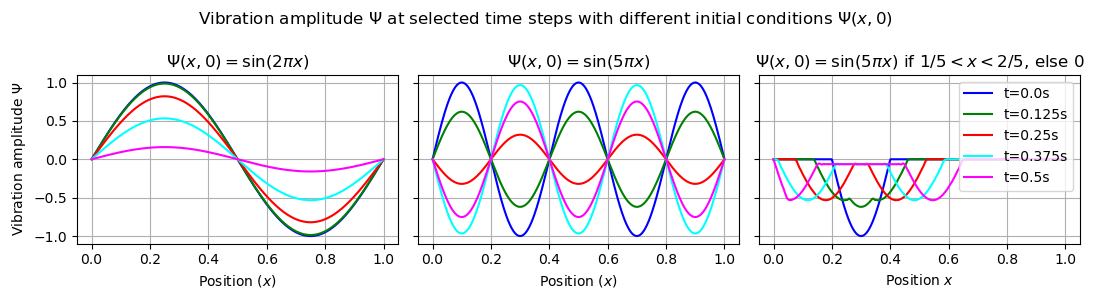

In [159]:
# Parameters
c = 1
L = 1

# Discretization
dt = 0.001
T = 0.5
Nx = 500
dx = L / Nx
Nt = int(T / dt)

init_conditions = [
    lambda x: np.sin(2 * np.pi * x),
    lambda x: np.sin(5 * np.pi * x),
    lambda x: np.where((1/5 < x) & (x < 2/5), np.sin(5 * np.pi * x), 0)
]

init_labels = [
    '$\\sin(2\\pi x)$',
    '$\\sin(5\\pi x)$',
    '$\\sin(5\\pi x)$ if $1/5 < x < 2/5$, else $0$'
]

psis = []
for i, (f0, init_label) in enumerate(zip(init_conditions, init_labels)):
    psi_matrix = solve_wave(f0, L, c, T, Nx, dt)
    psis.append(psi_matrix)


fig, axs = plt.subplots(1, 3, figsize=(11, 3), sharey=True, layout='tight')
times = np.linspace(0, T, 5)
time_labels = [f't={t}s' for t in times]
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
x = np.linspace(0, L, Nx)

for i, (c, init_label) in enumerate(zip(psis, init_labels)):
    for j, (t, time_label, color) in enumerate(zip(times, time_labels, colors)):
        axs[i].plot(x, c[:, int(Nt*t)], label=time_label, color=color)
    axs[i].set_title(f'$\\Psi(x,0)=${init_label}')
    axs[i].grid(True)
    axs[i].set_xlabel('Position ($x$)')
    axs[i].set_yticks([-1, -0.5, 0, 0.5, 1])
axs[0].set_ylabel('Vibration amplitude $\\Psi$')
axs[-1].legend(loc='upper right')

plt.suptitle('Vibration amplitude $\\Psi$ at selected time steps with different initial conditions $\\Psi(x,0)$')
plt.xlabel('Position $x$')
plt.savefig('media/wave_equation.png', dpi=300, bbox_inches='tight')
plt.show()

C. (1 point) Make an animated plot of the time development.

Animating wave: 100%|██████████| 3/3 [00:12<00:00,  4.33s/animation]


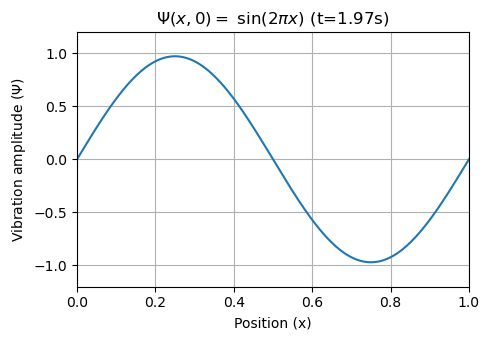

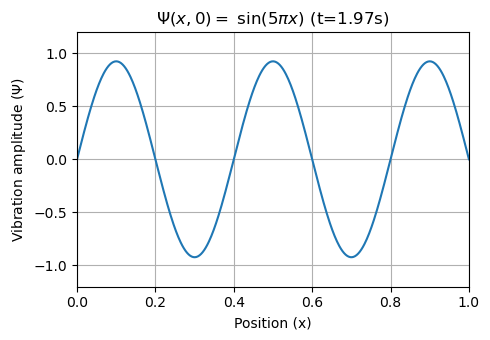

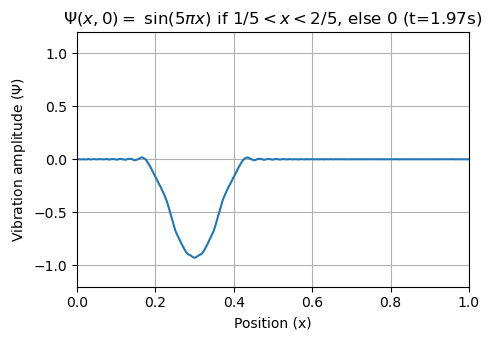

In [160]:
def animate_wave(psi, title, file_title, L=1.0, T=1.0, total_frames=100, save=False):
    fig, ax = plt.subplots(figsize=(5, 3.5), layout='tight')
    x = np.linspace(0, L, psi.shape[0])
    plt.xlim(0, L)
    plt.ylim(-1.2, 1.2)
    plt.xlabel('Position (x)')
    plt.ylabel('Vibration amplitude ($\\Psi$)')
    plt.grid(True)
    line, = ax.plot(x, psi[:,0])

    # Calculate the frame interval based on the total number of frames
    frame_interval = int(psi.shape[1] / total_frames)

    def animate(i):
        line.set_ydata(psi[:,i * frame_interval])
        plt.title(title + f' (t={i * frame_interval / psi.shape[1] * T:.2f}s)')
        return line,

    anim = FuncAnimation(fig, animate, frames=total_frames, interval=1000//60, blit=True, repeat=True)
    if save:
        anim.save(f'media/{file_title}.gif', writer='ffmpeg')

# Parameters
c = 1
L = 1

# Discretization
dt = 0.001
T = 2.0
Nx = 500
dx = L / Nx
Nt = int(T / dt)

for i, (init_condition, init_label) in tqdm(enumerate(zip(init_conditions, init_labels)), total=len(init_conditions), desc='Animating wave', unit='animation'):
    psi = solve_wave(init_condition, L, c, T, Nx, dt)
    anim = animate_wave(psi, f'$\\Psi(x,0) =$ {init_label}', f'animated_wave_{i}', T=T, total_frames=80, save=True)

### 1.2: Time Dependent Diffusion Equation

D. (0.5 point) Determine the equation to use at the boundaries of the domain.
Clearly show the ranges of the indices of the grid. A figure is extremely helpful for
figuring this out.

The equations relevant for all boundaries are
$$
\begin{align}
c(x, 0; t) = 0 &\land c(x, 1; t) = 1\\
c(0, y; t) = c(N-1, y; t) &\land c(N, y; t) = c(1, y; t)
\end{align}
$$
where equation 1 refers to the source and sink boundary conditions and equation 2 refers to the periodic boundary conditions in the x direction.

The chosen dt=0.01 is larger than the maximum stable dt=0.0001.
Setting dt to 5e-05 instead.


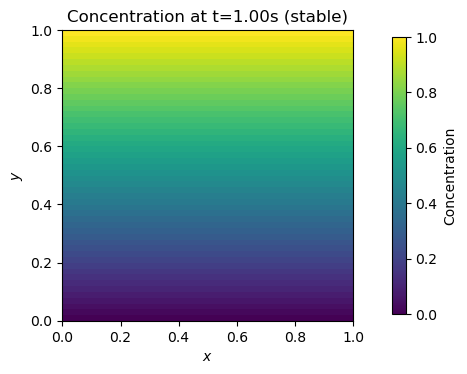

In [161]:
def diffusion_step(u, dt, dx):
    """Executes a single time step of the diffusion equation"""
    u_new = np.copy(u)
    u_new[1:-1, 1:-1] = u[1:-1, 1:-1] + (D * dt / dx**2) * (
        u[2:, 1:-1] + u[:-2, 1:-1] + u[1:-1, 2:] + u[1:-1, :-2] - 4 * u[1:-1, 1:-1])
    
    # Apply boundary conditions
    u_new[0, :] = u_new[-2, :]
    u_new[-1, :] = u_new[1, :]

    return u_new

def ensure_stable_dt(D, dx, dt):
    """Ensures that the time step dt is stable for the given model"""
    dt_stable = (dx**2) / (4 * D)
    if dt > dt_stable:
        print(f'The chosen dt={dt} is larger than the maximum stable dt={dt_stable}.')
        new_dt = dt_stable / 2 # Use half of the maximum stable dt instead
        print(f'Setting dt to {new_dt} instead.')
        return new_dt
    return dt

def solve_diffusion(Nx, D, dx, dt, T):
    """
    Simulate diffusion (2D spatial + time) and return the concentration matrix.

    Parameters:
    - Nx: Number of spatial grid points in each dimension
    - D: Diffusion constant
    - dx: Distance between grid points
    - dt: Time step size
    - T: Total time to simulate

    Returns:
    - c: Concentration matrix at each time step
    """
    dt = ensure_stable_dt(D, dx, dt)
    Nt = int(T / dt)

    # Initial & boundary conditions
    c = np.zeros((Nx, Nx, Nt + 1))
    c[:, -1] = 1
    
    for t in range(1, Nt + 1):
        c[1:-1, 1:-1, t] = c[1:-1, 1:-1, t-1] + (D * dt / dx**2) * (
            c[2:, 1:-1, t-1] + c[:-2, 1:-1, t-1] + c[1:-1, 2:, t-1] + c[1:-1, :-2, t-1] - 4 * c[1:-1, 1:-1, t-1])
        
        # Periodic boundary conditions
        c[0, :, t] = c[-2, :, t]
        c[-1, :, t] = c[1, :, t]
    
    return c

# Parameters
D = 1 # Diffusion coefficient
L = 1 # Length of the square spatial domain

# Discretization
T = 1.0
dt = 0.01
Nx = 50
dx = L / Nx

dt = ensure_stable_dt(D, dx, dt)
Nt = int(T / dt)

c = solve_diffusion(Nx, D, dx, dt, T)

# Plotting the final state
plt.figure(figsize=(5, 4))
plt.imshow(np.rot90(c[:,:,-1], 3), origin='lower', extent=(0, L, 0, L)) # TODO: cheated, this seems off
plt.colorbar(label='Concentration', shrink=0.9, pad=0.1)
plt.title(f'Concentration at t={T:.2f}s (stable)')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.savefig('media/diffusion_stable.png', dpi=300, bbox_inches='tight')
plt.show()

E. (1 point) Test the correctness of your simulation. Compare to the analytic
solutions, plot c(y) for different times.

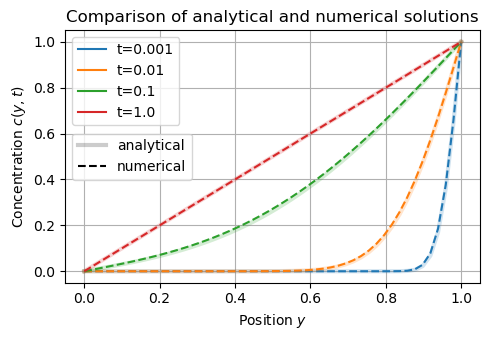

In [162]:
# Parameters and discretization identical to before

def solve_diffusion_analytical(y, t, terms=50):
    """Computes the analytical solution of the concentration c(y,t) using the error function."""
    result = 0
    for i in range(terms):
        result += erfc((1 - y + 2*i) / np.sqrt(4*D*t)) - erfc((1 + y + 2*i) / np.sqrt(4*D*t))
    return result

y = np.linspace(0, L, Nx)
time_values = np.logspace(-3, 0, 4)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
y_analyticals = []

for t in time_values:
    y_analyticals.append(solve_diffusion_analytical(y, t))

# Compare the analytical solution with the numerical solution
plt.figure(figsize=(5, 3.5), layout='tight')
lines = []
for i, (t, color) in enumerate(zip(time_values, colors)):
    plt.plot(y, c[0, :, int(t*Nt)], color=color, linestyle='--')
    plt.plot(y, y_analyticals[i], color=color, alpha=0.2, lw=3)
    lines.append(mlines.Line2D([], [], color=color, label=f't={t}'))
plt.title('Comparison of analytical and numerical solutions')
plt.xlabel('Position $y$')
plt.ylabel('Concentration $c(y,t)$')

# Double legend
analytical_line = mlines.Line2D([], [], color='black', alpha=0.2, lw=3, label='analytical')
numerical_line = mlines.Line2D([], [], color='black', linestyle='--', label='numerical')
type_legend = plt.legend(handles=[analytical_line, numerical_line], loc='center left')
plt.gca().add_artist(type_legend)
plt.legend(handles=lines, loc='upper left')

plt.grid(True)
plt.savefig('media/diffusion_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

F. (1 point) Plot the results, show the 2D domain, with a color representing the
concentration at each point. Make a plot of the state of the system at several times:
t = {0, 0.001, 0.01, 0.1, and 1}.

/var/folders/tg/bfb__1d16td__2vd879zjkrh0000gn/T/ipykernel_14049/2351817811.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('media/diffusion_at_different_times.png', dpi=300, bbox_inches='tight')
/opt/homebrew/Caskroom/miniconda/base/envs/ss-assignment-3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


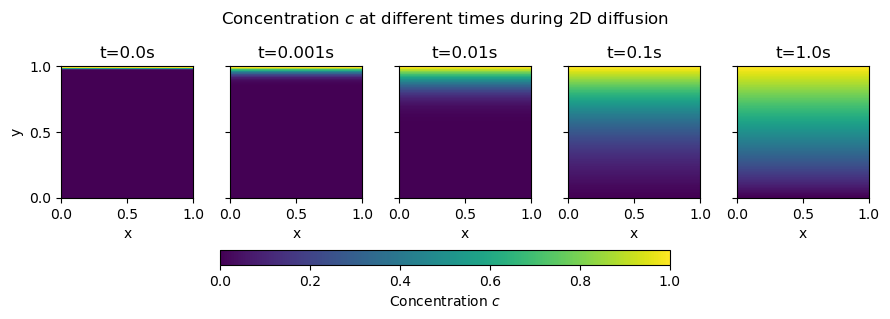

In [163]:
# Time points to capture the concentration
times_to_plot = np.array(np.array([0, 0.001, 0.01, 0.1, 1]) * Nt, dtype=int)

# Recalculate the simulation with tolerance for capturing times
c = solve_diffusion(Nx, D, dx, dt, T)

# Plotting with corrected results
fig, axs = plt.subplots(1, len(times_to_plot), figsize=(9, 3), sharey=True, layout='tight')
for i, t in enumerate(times_to_plot):
    im = axs[i].imshow(np.rot90(c[:,:,t], 3), extent=[0, L, 0, L], origin='lower') # TODO: cheated, this seems off
    axs[i].set_title(f't={t/Nt}s')
    axs[i].set_xlabel('x')
    axs[i].set_xticks([0, 0.5, 1])
    axs[i].set_yticks([0, 0.5, 1])
axs[0].set_ylabel('y')

# Add a colorbar on the bottom
cbar_ax = fig.add_axes((0.25, 0, 0.5, 0.05))
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Concentration $c$')

fig.suptitle('Concentration $c$ at different times during 2D diffusion', y=0.85)
plt.savefig('media/diffusion_at_different_times.png', dpi=300, bbox_inches='tight')
plt.show()

G. (1 point) Make an animated plot of the time dependent diffusion equation until
equilibrium.

In [164]:
def has_converged(c_old, c_new, epsilon=1e-5):
    """Check if the concentration matrix has converged to a steady state"""
    delta = np.max(np.abs(c_new - c_old))
    return delta < epsilon

def animate_diffusion(c, title, file_title, L, T, total_frames=100, save=False):
    fig, _ = plt.subplots(figsize=(5, 3.5), layout='tight')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    grid = plt.imshow(np.rot90(c[:,:,0], 3), extent=[0, L, 0, L], origin='lower')
    plt.colorbar(label='Concentration')

    # Calculate the frame interval based on the total number of frames
    frame_interval = int(c.shape[2] / total_frames)

    def animate(i):
        frame = i * frame_interval
        grid.set_data(np.rot90(c[:,:, frame], 3))
        plt.title(title + f' (t={frame / c.shape[2] * T:.2f}s)')
        return grid,

    anim = FuncAnimation(fig, animate, frames=total_frames, interval=1000//60, blit=True, repeat=True)
    if save:
        anim.save(f'media/{file_title}.gif', writer='ffmpeg')

Converged after 11268 time steps at time 0.56s.


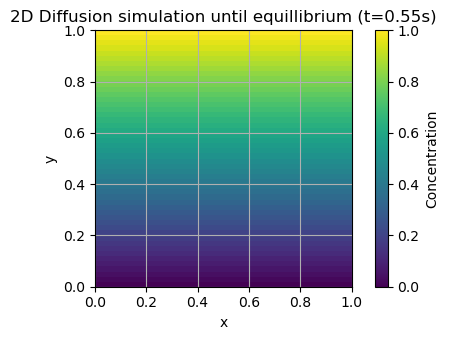

In [165]:
# Iterate until convergence
c = np.zeros((Nx, Nx, Nt+1))
c[:, -1, :] = 1

epsilon = 1e-6
timestep_equillibrium = 0
for i in range(Nt):
    c[:,:,i+1] = diffusion_step(c[:,:,i], dt, dx)
    if has_converged(c[:,:,i], c[:,:,i+1], epsilon=epsilon):
        timestep_equillibrium = i
        print(f'Converged after {i} time steps at time {i*dt:.2f}s.')
        break

if timestep_equillibrium == 0:
    print('No convergence reached.')

anim = animate_diffusion(c[:,:,:i], f'2D Diffusion simulation until equillibrium', f'2d_diffusion_until_equillibrium', L=L, T=i*dt, total_frames=80, save=True)

### Laplace Equation

H. (1 point) Implement the Jacobi iteration, the Gauss-Seidel method and SOR.
Try N = 50. Test the methods by comparing the result to the analytical result in
eq. (5), i.e. the linear dependence of the concentration on y.

Jacobi method: 4323 iter
Gauss-Seidel method: 2564 iter
Successive Over-Relaxation (SOR) method: 314 iter


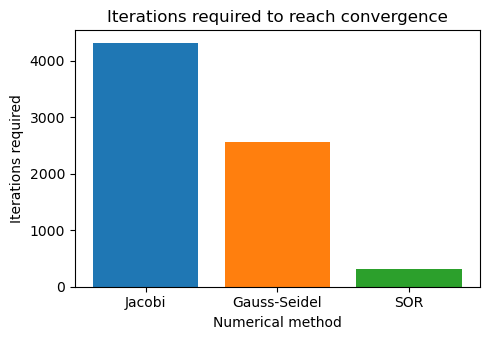

In [179]:
def jacobi_iter(c, Nx):
    c_new = c.copy()
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c_new[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])

    # Apply boundary conditions
    c_new[0, :] = c_new[-2, :]
    c_new[-1, :] = c_new[1, :]

    return c_new

def gauss_seidel(c, Nx):
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c[i, j] = 0.25 * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])

    # Apply boundary conditions
    c[0, :] = c[-2, :]
    c[-1, :] = c[1, :]

    return c

def sor_iter(c, Nx, omega):
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    
    # Apply boundary conditions
    c[0, :] = c[-2, :]
    c[-1, :] = c[1, :]

    return c

def solve_laplace(method, c, Nx, epsilon, omega=None):
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi_iter(c, Nx)
        elif method == 'gs':
            c = gauss_seidel(c, Nx)
        elif method == 'sor':
            c = sor_iter(c, Nx, omega)
        iteration += 1
        if has_converged(c_old, c, epsilon):
            break
    return c, iteration

# Parameters
sor_omega = 1.9
epsilon = 1e-5  # checking for convergence
L = 1.0 # Length of the square spatial domain

# Discretization
Nx = 50
x = np.linspace(0, L, Nx+2)
dx = x[1] - x[0]

# Initial conditions
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1

# Solve the Laplace equation using different methods
c_jacobi, iterations_jacobi = solve_laplace('jacobi', c.copy(), Nx, epsilon)
print(f'Jacobi method: {iterations_jacobi} iter(s)')
c_gs, iterations_gs = solve_laplace('gs', c.copy(), Nx, epsilon)
print(f'Gauss-Seidel method: {iterations_gs} iter(s))')
c_sor, iterations_sor = solve_laplace('sor', c.copy(), Nx, epsilon, sor_omega)
print(f'Successive Over-Relaxation (SOR) method: {iterations_sor} iter(s)')

In [194]:
# Analytical solution (assuming a linear dependence on x)
c_analytical = np.zeros((Nx+2, Nx+2))
for i in range(Nx+2):
    c_analytical[:, i] = x[i]

# Calculate errors compared to analytical solution
error_jacobi = np.abs(c_jacobi - c_analytical)
error_gs = np.abs(c_gs - c_analytical)
error_sor = np.abs(c_sor - c_analytical)

# Maximum error
max_error_jacobi = np.max(error_jacobi)
max_error_gs = np.max(error_gs)
max_error_sor = np.max(error_sor)

# Mean Squared Error
mse_jacobi = np.mean((c_analytical - c_jacobi) ** 2)
mse_gs = np.mean((c_analytical - c_gs) ** 2)
mse_sor = np.mean((c_analytical - c_sor) ** 2)

rmse_jacobi = np.sqrt(mse_jacobi)
rmse_gs = np.sqrt(mse_gs)
rmse_sor = np.sqrt(mse_sor)

print(f'Max error (Jacobi): {max_error_jacobi:.2e}, Max error (Gauss-Seidel): {max_error_gs:.2e}, Max error (SOR): {max_error_sor:.2e}')
print(f'MSE (Jacobi): {mse_jacobi:.2e}, MSE (Gauss-Seidel): {mse_gs:.2e}, MSE (SOR): {mse_sor:.2e}')
print(f'RMSE (Jacobi): {rmse_jacobi:.2e}, RMSE (Gauss-Seidel): {rmse_gs:.2e}, RMSE (SOR): {rmse_sor:.2e}')

Max error (Jacobi): 1.05e-02, Max error (Gauss-Seidel): 5.32e-03, Max error (SOR): 5.90e-05
MSE (Jacobi): 5.44e-05, MSE (Gauss-Seidel): 1.37e-05, MSE (SOR): 1.17e-09
RMSE (Jacobi): 7.37e-03, RMSE (Gauss-Seidel): 3.70e-03, RMSE (SOR): 3.42e-05


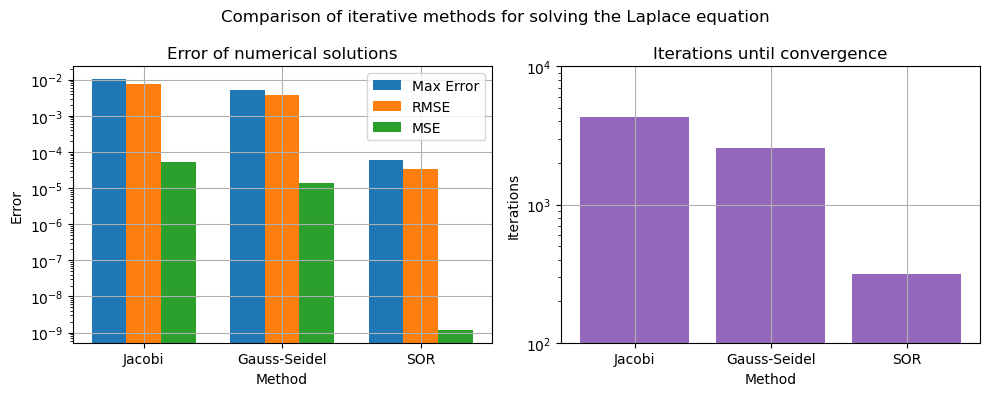

In [215]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout='tight')
methods = ['Jacobi', 'Gauss-Seidel', 'SOR']
bar_width = 0.25
b1 = np.arange(len(methods))
b2 = [x + bar_width for x in b1]
b3 = [x + 2*bar_width for x in b1]

axs[0].bar(b1, [max_error_jacobi, max_error_gs, max_error_sor], color='tab:blue', width=bar_width, label='Max Error')
axs[0].bar(b2, [rmse_jacobi, rmse_gs, rmse_sor], color='tab:orange', width=bar_width, label='RMSE')
axs[0].bar(b3, [mse_jacobi, mse_gs, mse_sor], color='tab:green', width=bar_width, label='MSE')
axs[0].set_xlabel('Method')
axs[0].set_xticks([r + bar_width for r in range(len(methods))])
axs[0].set_xticklabels(methods)
axs[0].set_ylabel('Error')
axs[0].set_yscale('log')
axs[0].set_title('Error of numerical solutions')
axs[0].grid(True)
axs[0].legend()

iterations = [iterations_jacobi, iterations_gs, iterations_sor]
axs[1].bar(methods, iterations, color=['tab:purple'])
axs[1].set_xlabel('Method')
axs[1].set_ylabel('Iterations')
axs[1].set_yscale('log')
axs[1].set_yticks([100, 1000, 10000])
axs[1].set_title('Iterations until convergence')
axs[1].grid(True)

plt.suptitle('Comparison of iterative methods for solving the Laplace equation')
plt.savefig('media/laplace_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

I. (1 point) Show how the convergence measure δ in eq. (14) depends on the number
of iterations k for each of the methods. A log-lin plot may be suitable. For SOR,
choose a few representative values for ω.

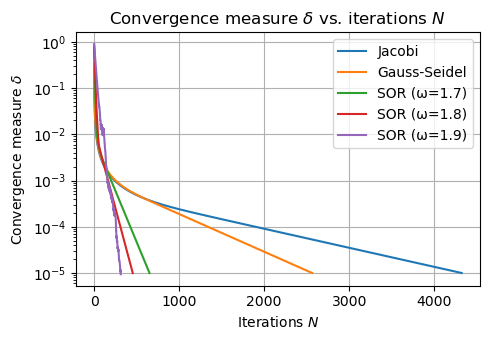

In [169]:
def track_delta(method, c, Nx, omega=None):
    """Counts the number of iterations for each method to converge and returns the deltas (change in c) over time."""
    deltas = []
    epsilon = 1e-5
    iteration = 0
    while True:
        c_old = c.copy()
        if method == 'jacobi':
            c = jacobi_iter(c, Nx)
        elif method == 'gs':
            c = gauss_seidel(c, Nx)
        elif method == 'sor':
            c = sor_iter(c, Nx, omega)
        delta = np.max(np.abs(c_old - c))
        deltas.append(delta)
        iteration += 1
        if delta < epsilon:
            break
    return deltas

c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1 
delta_jacobi = track_delta('jacobi', c.copy(), Nx)

c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1 
delta_gs = track_delta('gs', c.copy(), Nx)

omega_values = [1.7, 1.8, 1.9]
c = np.zeros((Nx+2, Nx+2))  
c[:, 0] = 0  
c[:, -1] = 1 
delta_sor = {omega: track_delta('sor', c.copy(), Nx, omega) for omega in omega_values}

plt.figure(figsize=(5, 3.5), layout='tight')
plt.plot(delta_jacobi, label='Jacobi')
plt.plot(delta_gs, label='Gauss-Seidel')
for sor_omega, deltas in delta_sor.items():
    plt.plot(deltas, label=f'SOR (ω={sor_omega})')
plt.yscale('log')
plt.xlabel('Iterations $N$')
plt.ylabel('Convergence measure $\\delta$')
plt.title('Convergence measure $\\delta$ vs. iterations $N$')
plt.legend()
plt.grid(True)
plt.savefig('media/convergence_measure.png', dpi=300, bbox_inches='tight')
plt.show()

J. (1 point) In the SOR method, find the optimal ω. How does it depend on N?.

In [170]:
@jit(nopython=True, parallel=True)
def sor_parallel(c, omega, N, tolerance=1e-6, max_iterations=10000):
    """Solves the Laplace equation using the red-black parallel Successive Over-Relaxation (SOR) method"""
    converged = False
    for iteration in range(max_iterations):
        c_old = c.copy()  # Copy the grid for convergence check
        
        # Update red points
        for i in prange(1, N+1):
            for j in range(1, N+1):
                if (i + j) % 2 == 0:
                    c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
        
        # Update black points
        for i in prange(1, N+1):
            for j in range(1, N+1):
                if (i + j) % 2 == 1:
                    c[i, j] = (1-omega)*c[i, j] + omega*0.25*(c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])

        # Apply boundary conditions
        c[0, :] = c[-2, :]
        c[-1, :] = c[1, :]
        
        # Convergence check
        diff = np.max(np.abs(c - c_old))
        if diff < tolerance:
            converged = True
            break
    
    return c, iteration, converged

def find_best_omega(N, omega_values, tolerance=1e-6, max_iterations=10000):
    """Finds the best relaxation parameter omega for SOR"""
    best_omega = 0
    min_iterations = max_iterations
    for omega in omega_values:
        c = np.zeros((N+2, N+2))
        c[:, 0] = 0
        c[:, -1] = 1
        _, iterations, converged = sor_parallel(c, omega, N, tolerance, max_iterations)
        if converged and iterations < min_iterations:
            min_iterations = iterations
            best_omega = omega
    return best_omega, min_iterations

# Example usage
# N = 100
# omega_range = np.linspace(1.7, 2.0, 16)
# best_omega, min_iterations = find_best_omega(N, omega_range)
# print("Best omega:", best_omega, "with iterations:", min_iterations)

Finding best omega for each grid size:   0%|          | 0/39 [00:00<?, ?grid/s]

Finding best omega for each grid size: 100%|██████████| 39/39 [05:01<00:00,  7.73s/grid]


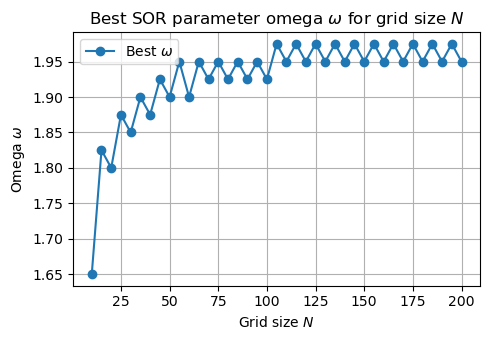

In [171]:
grid_sizes = np.arange(10, 205, 5)
omega_range = np.arange(1.5, 2, 0.025)

best_omegas = []
min_iterations_list = []

for N in tqdm(grid_sizes, desc='Finding best omega for each grid size', unit='grid'):
    best_omega, min_iterations = find_best_omega(N, omega_range)
    best_omegas.append(best_omega)
    min_iterations_list.append(min_iterations)
    # print(f"Grid Size: {N}, Best Omega: {best_omega:.4f}, Min Iterations: {min_iterations}")

plt.figure(figsize=(5, 3.5), layout='tight')
plt.plot(grid_sizes, best_omegas, '-o', label='Best $\\omega$')
plt.xlabel('Grid size $N$')
plt.ylabel('Omega $\\omega$')
plt.title('Best SOR parameter omega $\\omega$ for grid size $N$')
plt.grid(True)
plt.legend()
plt.savefig('media/best_omega.png', dpi=300, bbox_inches='tight')
plt.show()

In [172]:
# # Define grid sizes to test
# grid_sizes = [20, 50, 100]  # different N sizes 
# omega_range = np.linspace(1.7, 2.0, 5)  # range of omega to test


# # find optimal ω for different grid sizes
# # def omega_parameter(grid_sizes, omega_range):
# optimal_omegas = {}
# for Nx in grid_sizes:
#     iterations_for_omegas = []
#     for omega in omega_range:
#         # Setup the grid and boundary conditions again for each N
#         c = np.zeros((Nx+2, Nx+2))  
#         y_list = np.linspace(0, 1, Nx+2)
#         c[:, 0] = y_list  
#         c[:, -1] = y_list 
#         _, iterations = solve_laplace('sor', c.copy(), omega)
#         iterations_for_omegas.append(iterations)
    
#     # Omega with least iterations
#     min_iterations = min(iterations_for_omegas)
#     optimal_omega = omega_range[iterations_for_omegas.index(min_iterations)]
#     optimal_omegas[Nx] = (optimal_omega, min_iterations)

#     # return optimal_omegas


# # best_omega = omega_parameter(grid_sizes, omega_range)
# # best_omega

K. (2 points) Implement the possibility to include objects into the computational
domain. The objects should be sinks. Experiment a little bit with some objects in
the computational domain (e.g. a rectangle or a few rectangles, ...). What is the
influence on the number of iterations. What about the optimal ω , is it influenced
by the presence of objects? Look at the resulting concentration fields, and try to
interpret what happens. The implementation in this exercise will also be used for
diffusion-limited aggregation in Set 2.

Simulating SOR with sink:   0%|          | 39/10000 [00:00<00:26, 375.83iteration/s]

Simulating SOR with sink:   6%|▌         | 551/10000 [00:01<00:17, 528.24iteration/s]


Converged in 552 iterations


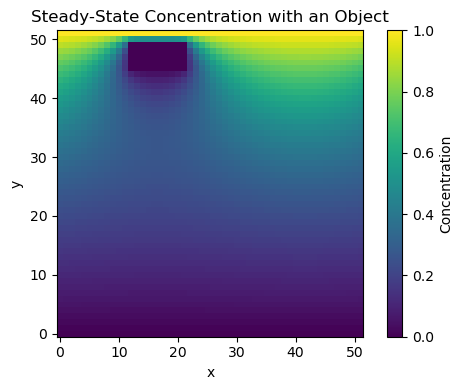

In [173]:
# Parameters
Nx = 50  # Grid size
omega = 1.7  # Over-relaxation parameter, to be adjusted based on experimentation
epsilon = 1e-5  # Convergence criteria
max_iterations = 10000  # Maximum number of iterations to prevent infinite loops

# Initialize the computational grid
c = np.zeros((Nx+2, Nx+2))
# Boundary conditions
c[:, 0] = 0
c[:, -1] = 1 

# a rectangular object encoded in the domain
objects = np.zeros((Nx+1, Nx+1), dtype=int)
objects[3*Nx//5:4*Nx//5, 9*Nx//10:Nx] = 1  # Representing the object as a rectangle

def update(c, objects):
    c_new = c.copy()
    for i in range(1, Nx+1):
        for j in range(1, Nx+1):
            if objects[i, j] == 0:  # Check if the point is not part of an object
                c_new[i, j] = (1 - omega) * c[i, j] + (omega / 4) * (
                    c[i+1, j] + c_new[i-1, j] + c[i, j+1] + c_new[i, j-1]
                )
            else:
                c_new[i, j] = 0  # Set concentration to zero if it's part of an object

    # Apply boundary conditions
    c_new[0, :] = c_new[-2, :]
    c_new[-1, :] = c_new[1, :]
    
    return c_new

# Iteration
for iteration in tqdm(range(max_iterations), desc='Simulating SOR with sink', unit='iteration'):
    c_new = update(c, objects)
    # Check for convergence
    delta = np.max(np.abs(c_new - c))
    if delta < epsilon:
        print(f"Converged in {iteration+1} iterations")
        break
    c = c_new
else:
    print("Maximum iterations reached without convergence")

# Plotting
plt.figure(figsize=(5, 4), layout='tight')
plt.imshow(np.rot90(c, 3), interpolation='nearest', origin='lower')
plt.colorbar(label='Concentration')
plt.title('Steady-State Concentration with an Object')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig("media/sink_simple_object.png", dpi=300, bbox_inches='tight')
plt.show()

Optional. (1 point) Think of a way to incorporate objects with insulating material in your domain. What changes in the time evolution of the system? And in the ﬁnal state?

In [174]:
# # Parameters
# Nx = 50  # Grid size
# omega = 1.7  # Over-relaxation parameter
# epsilon = 1e-5  # Convergence criteria
# max_iterations = 10000  # Maximum number of iterations to prevent infinite loops

# # Initialize the computational grid
# c = np.zeros((Nx+2, Nx+2))
# # Boundary conditions
# c[:, 0] = 0  # Bottom
# c[:, -1] = 1  # Top

# # a rectangular object encoded in the domain
# # adjust to include an insulating object
# # 0: Normal point, 1: Sink, 2: Insulator
# objects = np.zeros((Nx+1, Nx+1), dtype=int)
# objects[3*Nx//5:4*Nx//5, 9*Nx//10:Nx] = 2  # Representing the object as a rectangle

# def update_with_insulator(c, objects):
#     c_new = c.copy()
#     for i in range(1, Nx+1):
#         for j in range(1, Nx+1):
#             if objects[i, j] == 1:  # Sink
#                 c_new[i, j] = 0
#             elif objects[i, j] == 2:  # Insulator, enforce no-flux boundary by not updating these edges
#                 pass  # No action needed, concentration remains unchanged
#             else:  # Normal update rule
#                 c_new[i, j] = (1 - omega) * c[i, j] + (omega / 4) * (
#                     c[i+1, j] + c_new[i-1, j] + c[i, j+1] + c_new[i, j-1]
#                 )
#     # Apply boundary conditions
#     c_new[0, :] = c_new[-2, :]
#     c_new[-1, :] = c_new[1, :]
    
#     return c_new

# # Re-initialize the concentration matrix
# c = np.zeros((Nx+2, Nx+2))
# c[:, 0] = 0
# c[:, -1] = 1

# # Iteration with insulating object
# for iteration in tqdm(range(max_iterations), desc='Simulating SOR with Insulator', unit='iteration'):
#     c_new = update_with_insulator(c, objects)
#     # Check for convergence
#     delta = np.max(np.abs(c_new - c))
#     if delta < epsilon:
#         print(f"Converged in {iteration+1} iterations") # Iteration starts at 0
#         break
#     c = c_new
# else:
#     print("Maximum iterations reached without convergence")

# # Plotting
# plt.imshow(np.rot90(c, 3), interpolation='nearest', origin='lower')
# plt.colorbar(label='Concentration')
# plt.title('Steady-State Concentration with an Insulating Object')
# # plt.show()
# plt.savefig("media/insulating.jpg")

Converged in 953 iterations with insulating objects


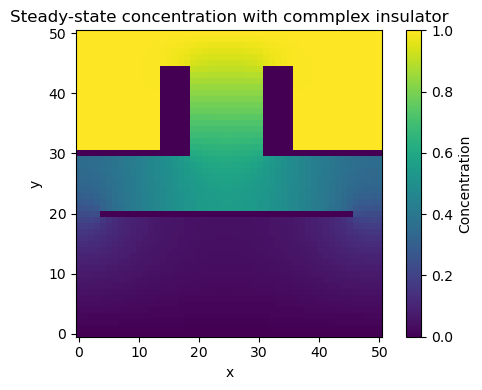

In [175]:
def update_with_insulation(c, Nx, objects):
    c_new = c.copy()
    for i in range(1, Nx):
        for j in range(1, Nx):
            if objects[i, j] == 0:  # Not part of an object
                contributions = []
                # Check each neighbor and add it to the contributions if it's not an insulating material
                if objects[i+1, j] != 2:
                    contributions.append(c[i+1, j])
                if objects[i-1, j] != 2:
                    contributions.append(c_new[i-1, j])
                if objects[i, j+1] != 2:
                    contributions.append(c[i, j+1])
                if objects[i, j-1] != 2:
                    contributions.append(c_new[i, j-1])

                # Calculate new concentration based on available contributions
                if contributions:
                    c_new[i, j] = (1 - omega) * c[i, j] + omega * sum(contributions) / len(contributions)
                else:
                    c_new[i, j] = c[i, j]  # No update if completely surrounded by insulators
            # No else case needed; insulating objects do not change concentration
                    
    # Apply boundary conditions
    c_new[0, :] = c_new[-2, :]
    c_new[-1, :] = c_new[1, :]

    return c_new

# Adjusting the previous implementation to incorporate insulating objects
# For simplicity, we'll use the same object matrix but now treat it as insulating
objects = np.zeros((Nx+2, Nx+2), dtype=int)
objects[15:20, 3*Nx//5:int(4.5*Nx//5)] = 2
objects[-20:-15, 3*Nx//5:int(4.5*Nx//5)] = 2
objects[:20, 3*Nx//5] = 2
objects[-20:, 3*Nx//5] = 2
objects[5:-5, 2*Nx//5] = 2

# Iteration with insulating objects
c = np.zeros((Nx+1, Nx+1))
c[:, -1] = 1

for iteration in range(max_iterations):
    c_new = update_with_insulation(c, Nx, objects)
    delta = np.max(np.abs(c_new - c))
    if delta < epsilon:
        print(f"Converged in {iteration+1} iterations with insulating objects")
        break
    c = c_new
else:
    print("Maximum iterations reached without convergence with insulating objects")

# Plotting
plt.figure(figsize=(5, 4), layout='tight')
plt.imshow(np.rot90(c, 3), interpolation='nearest', origin='lower')
plt.colorbar(label='Concentration')
plt.title('Steady-state concentration with commplex insulator')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig("media/insulator_complex_shape.png", dpi=300, bbox_inches='tight')
plt.show()